##### Quantum Data Science 2023/2024

# Lecture 10 - Quantum Approximate Optimization Algorithm (QAOA)
*Machine Learning with quantum computers -  Section 3.6.5.2*

<!-- no toc -->
### Contents 

1. [Variational Quantum Algorithms](#VQAs)
2. [QAOA for combinatorial optimization problems](#quadratic_programs)
3. [The QAOA circuit](#qaoa_circuit)
4. [From Adiabatic Optimization to QAOA](#intro)
5. [Caveats](#caveats)
6. [The MaxCut problem](#maxcut)
7. [QAOA implementation](#qaoa_maxcut)
8. [QAOA from qiskit_algorithms](#qiskit_algorithms)
9. [References](#references)

## 1. Variational Quantum Algorithms 
<a id="VQAs"></a>


<p align="center">
 <img width="1000" height="550" src="images/VQA_loop.png">
</p>


In variational quantum algorithms we use a variational quantum circuit , that is, a quantum circuit with parameterized rotations, that will be iteratively learned to minimize/maximize a given objetive function. The objetive function is thus a classical post-processing function of the expectation value of a given observable for the problem at hand.

The QAOA algorithm is a variational quantum algorithm with a *problem-dependent ansatz*. That is, in these cases we know how to encode the problem that we want to solve into a Hamiltonian that is further translated into the ansatz. However, not all problems can be fit into QAOA.

QAOA is a special case of the VQE algorithm , but it is tipically used to solve Quadratic problems since it is known how to map them into Hamiltonians. 

## 2. QAOA for combinatorial optimization problems
<a id="quadratic_programs"></a>

The quadratic programming problem with $n$ variables and $m$ constraints can be formulated as follows. Given:
- a real-valued, $n$-dimensional vector $\mathbf{c}$,
- an $n \times n$-dimensional real symmetric matrix $Q$,
- an $m \times n$-dimensional real matrix $A$, and
- an $m$-dimensional real vector $\mathbf{b}$,
the objective of quadratic programming is to find an $n$-dimensional vector $\mathbf{x}$, that will
$$
\begin{array}{ll}
\text { minimize } & \mathbf{x}^{\mathrm{T}} Q \mathbf{x}+\mathbf{c}^{\mathrm{T}} \mathbf{x} \\
\text { subject to } & A \mathbf{x} \preceq \mathbf{b},\  x^T Q x + c^T x \leq r
\end{array}
$$
where $\mathbf{x}^{\mathrm{T}}$ denotes the vector transpose of $\mathbf{x}$, and the notation $A \mathbf{x} \leq \mathbf{b}$ means that every entry of the vector $A \mathbf{x}$ is less than or equal to the corresponding entry of the vector $\mathbf{b}$ (component-wise inequality).

QUBO's (Quadratic Unconstrained Binary Optimization problems) are the ones to be solved by the QAOA. In this case, we don't have constraints and a binary string $x \in \{0,1\}^n$ encodes the solution of the problem. 

\begin{equation}
f_Q(x)=x^{\top} Q x c^T x = \sum_{i=1}^n \sum_{j=i}^n Q_{i j} x_i x_j + \sum_{i=1}^n c_i x_i
\end{equation}


The goal will be to encode the problem of interest represented as a QUBO into a Hamiltonian.


THE GROUND STATE OF THE PROBLEM HAMILTONIAN WILL BE THE SOLUTION OF THE PROBLEM WE WANT TO SOLVE. QAOA WILL BE USED TO FIND THE GROUND STATE.

## 3. The QAOA circuit <a id="qaoa_circuit"></a>

In the QAOA literature the two blocks are known as:
  - $H_p$ - Problem Hamiltonian 
  - $H_0$ - Mixer Hamiltonian
  
<p align="center">
  <img width="800" height="300" src="images/qaoa.png">
</p>

Suppose the state prepared by the QAOA circuit $|\psi(\alpha,\beta)\rangle$. Now we can variationally optimize the parameters $(\alpha,\beta)$ to obtain the ground state of the problem hamiltonian. Remember that the ground state encodes the solution of our problem of interest! 

Usually, since we start from the uniform superposition, $H_p$ is usually composed by rotations in $Z$. Thus what that we need to do in order to find the ground state, is to minimize the expectation value of the problem Hamiltonian $H_p$.

$$ (\alpha^*,\beta^*) \leftarrow \argmin_{\alpha,\beta} \langle \psi(\alpha,\beta)|H_p|\psi(\alpha,\beta)\rangle$$

At the end of the optimization procedure, the basis state with highest probability, correspond to the solution to our problem! 


## 4. From Adiabatic Optimization to QAOA
<a id="intro"></a>

### Quantum Adiabatic Optimization 

Suppose we have a Hamiltonian $H_p$ whose ground state encodes the solution of a given problem of interest. If we prepare a quantum system in the ground state of a given hamiltonian $H_0$ that **does not** commute with $H_p$, then the *adiabatic theorem* of quantum mechanics says that if we evolve the quantum system with the Hamiltonian 

$$ H(t) = (1 - \frac{t}{T}) H_0 + \frac{t}{T} H_p$$ 

For time $T$ *slowly* enough, then the system will converge to the ground state of the problem Hamiltonian, and we will be able to measure the solution to our problem. 
Recall that the time evolution of a quantum system is given by solving the schrodinger equation: 

\begin{align*}
 i \hbar \frac{d}{dt}|\psi(t) \rangle &= H|\psi(t)\rangle \\ 
 |\psi(t) \rangle &= e^{\frac{-iHt}{\hbar}} |\psi(0)\rangle
\end{align*}

Remember this ! It will be important!

Now, there are two questions: 
 * How do we embed a problem of interest into a Hamiltonian? Moreover, what types of problems can we solve ? 
 * What is the initial Hamiltonian $H_0$ ? 

There are numerous ways of constructing problem hamiltonians, depending on the class of problems we are working. Essentially, any problem that can be mapped to a *satisfiability* problem can be "tried" to be solved using adiabatic evolution! *Quadratic Unconstrained Binary Optimization (QUBO)* is the most used class of problems since they can be mapped to the well-known *Ising model*, which is well established in terms of the correspondent hamiltonian, having at most two-qubit interactions. Check reference **[1]** to learn more about translating problems into Ising models. 

$H_0$ is regarded as a simple initial hamiltonian that we can prepare, and we know its ground state.

### How can we translate adiabatic optimization to the circuit model of quantum computing?

Notice that the quantum evolution is given by a unitary $U = e^{\frac{-iHt}{\hbar}}$. Now, the Hamiltonian is composed of two terms, $H_0$ and $H_p$ composed of matrices (Pauli matrices). Let us ignore time and plank's constant for now. We can separate the exponential of a sum of matrices by the product of the terms individually: 

$$e^H = e^{H_0 + H_p} = e^{H_0} e^{H_p}$$

However, this is true **only** when $H_0$ and $H_p$ commute. Nonetheless, we can approximate it using the **Trotter-suzuki** formula: 

$$ e^H = e^{H_0 + H_p} \approx (e^{\frac{H_0}{p}} e^{\frac{H_p}{p}})^p$$

The approximation converges in the limit of $\infty$ $p$. 

##### Still keep in mind that perhaps we do not need $\infty$ $p$ to have a fairly good approximation for our purposes!!!

Now, the exponential of Pauli matrices forms rotation matrices. 

<p align="center">
 <img width="800" height="350" src="images/matrix_exp.png">
</p>


For the case of two qubit interactions, the matrix exponential of a tensor product of Pauli matrices reduces to the direct sum of rotation gates:

\begin{equation}
\begin{aligned}
& e^{-i \frac{\theta}{2} \sigma_z \otimes \sigma_z}=e^{-i \frac{\theta}{2} \sigma_z} \oplus e^{i \frac{\theta}{2} \sigma_z} \\
& =R_z(\theta) \oplus R_z(-\theta) \\
& =\left(\begin{array}{cc}
R_z(\theta) & 0 \\
0 & R_z(-\theta)
\end{array}\right) \\
& =\left(\begin{array}{ccc}
e^{-i \frac{\theta}{2}} & 0 & 0 & 0 \\
0 & e^{i \frac{\theta}{2}} & 0 & 0\\
0 & 0 & e^{i \frac{\theta}{2}} & 0\\
0 & 0 & 0 & e^{-i \frac{\theta}{2}}
\end{array}\right) \\
&
\end{aligned}
\end{equation}

Thus, we just need to repeat these unitaries $p$ times in our quantum circuit. 

<p align="center">
 <img width="500" height="200" src="images/trotter.png">
</p>

The difficulty lies in designing the time $t$ in the circuit model. For that reason, we will consider parameters $\alpha$ and $\beta$ that will be variationally optimized to converge to the ground state of our problem hamiltonian. 

<p align="center">
 <img width="500" height="200" src="images/alphas_betas.png">
</p>

### At this point, we almost have the QAOA circuit. The initial Hamiltonian $H_0$, is the only thing that it is missing.

$H_0$ is usually regarded as a series of Pauli $\sigma_x$ gates on each qubit, in which the exponential transforms them into rotation gates of the form $R_x(2\beta)$. This form of $H_0$ is considered since we know how to create the ground state. You see, the ground state corresponds simply to the uniform superposition state! 

At this point, we arrived at the final form of the QAOA circuit, motivating each block! 

### The full QAOA circuit <a id="qaoa_circuit"></a>

In the QAOA literature the two blocks are known as:
  - $H_p$ - Problem Hamiltonian 
  - $H_0$ - Mixer Hamiltonian
  
<p align="center">
  <img width="800" height="300" src="images/qaoa.png">
</p>

Suppose the state prepared by the QAOA circuit $|\psi(\alpha,\beta)\rangle$. Now we can variationally optimize the parameters $(\alpha,\beta)$ to obtain the ground state of the problem hamiltonian. Remember that the ground state encodes the solution of our problem of interest! 

Usually, since we start from the uniform superposition, $H_p$ is usually composed by rotations in $Z$. Thus what that we need to do in order to find the ground state, is to minimize the expectation value of the problem Hamiltonian $H_p$.

$$ (\alpha^*,\beta^*) \leftarrow \argmin_{\alpha,\beta} \langle \psi(\alpha,\beta)|H_p|\psi(\alpha,\beta)\rangle$$

At the end of the optimization procedure, the basis state with highest probability, correspond to the solution to our problem! 

### 5. Caveats <a id="caveats"></a>

- sampling from even for small circuit depths $p$ is classically intractable, which gives this model a potential exponential quantum advantage.
- QAOA performance should increase with an increasing number of layers $p$
- However, QAOA has no performance guarantees for finite $p$ 
- Limited device connectivity , so complex hamiltonians might neglect any possible advantage. 
- Increasing number of shots and iterations for increasing problem size. 
- Even though QAOA output distribution is hard to represent, some problems can be solved more efficiently using classical algorithms. Some examples depth 1 is efficiently reproduced by a classical algorithm.
- Barren plateaus also happen for QAOA (in some configurations) [7]

### 6. The MaxCut problem <a id="maxcut"></a>

A Max-Cut problem involves partitioning nodes of a graph into two sets, such that the number of edges between the sets is maximum. We can use networkx to create graphs. Below is an example of a graph with 5 nodes, and an example of a partition between "purple" and "blue" nodes

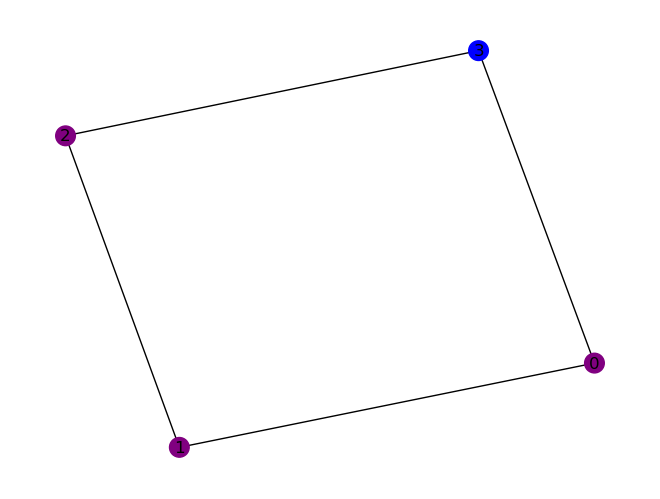

In [3]:
import networkx as nx

n_qubits = 4

G = nx.Graph()
G.add_nodes_from(list(range(n_qubits)))
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, node_color=["purple","purple","purple","blue"],node_size=200)


In this case, for 4 nodes, as each node can be assigned to either the "purple" or "blue" sets. There are $2^4 = 16$ possible assignments. In the graph above, there are 2 edges connecting the two sets. Thus, the cut is 2. The goal is to maximize the number of edges between sets, hence maximum cut. 


<p align="center">
  <img width="900" height="350" src="images/maxcut.jpeg">
</p>

For a graph with 4 nodes, the maximum cut corresponds to an alternated bitstring Eg: 1010

Let's consider the adjacency matrix for the graph: 

\begin{equation*}
    A_{ij} = 
    \begin{pmatrix}
    0 & 1 & 0 & 1\\
    1 & 0 & 1 & 0\\
    0 & 1 & 0 & 1\\
    1 & 0 & 1 & 0
    \end{pmatrix}
\end{equation*}

In a general *weighted undirected graph*, we have an adjacency matrix:


\begin{equation*}
    A_{ij} = 
    \begin{pmatrix}
    w_{00} & w_{01} & w_{02} & w_{03}\\
    w_{10} & w_{11} & w_{12} & w_{13}\\
    w_{20} & w_{21} & w_{22} & w_{23}\\
    w_{30} & w_{31} & w_{32} & w_{33}
    \end{pmatrix}
\end{equation*}

You can obtain the adjacency matrix from networkx:


In [4]:
A = nx.adjacency_matrix(G).todense()
print(A)


[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


The MaxCut problem can be solved by maximizing the following cost:

$$ C(x) = \sum_{i,j} w_{ij} x_i(1-x_j)$$ 

i.e. find the bitstring x that maximizes the cut 

In order to translate the the cost into a Hamiltonian we apply:

map $x_i \mapsto \frac{1 - \sigma_{z_i}}{2}$ because we want to work with spin systems and the eigenvalues encode the solution -> $\sigma_z \in \{-1,1\}$


$$ \sigma_{z_i}|x\rangle = (-1)^{x_i}|x\rangle $$


If we use the mapping we arrive at the Hamiltonian,

$$ H_p = \frac{1}{2} \sum_{i,j} w_{ij} (1 - \sigma_{z_i}\sigma_{z_j})$$


### 7. QAOA implementation <a id="qaoa_maxcut"></a>

### Libraries and functions 

In [5]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit.circuit import Parameter

In [6]:
from qiskit import *
from qiskit.primitives import Sampler,Estimator
import numpy as np
import matplotlib.pyplot as plt

def execute_circuit(qc, shots=1024, seed=None, binary=False , primitive="sampler", observable=None, reverse=False):
    
    if reverse:
        qc = qc.reverse_bits()

    if primitive == "estimator":
        options = {"shots": shots, "seed": seed}
        estimator = Estimator(options=options)
    
        job = estimator.run(qc, observable)
        result = job.result()  
        
        return result
    
    elif primitive == "sampler":
        options = {"shots": shots, "seed": seed}
        sampler = Sampler(options=options)
    
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            
            probability_dictionary = probability_dictionary.binary_probabilities()

            
        return probability_dictionary
    

<span style="color: red;">EXERCISE 4.1</span> - Implement the quantum circuit for the MaxCut problem Hamiltonian. Notice that you don't need to include rotations in the circuit that with zero angle. 

In [7]:
# G -> graph || A -> Adjacency matrix || alpha -> parameter 
# alpha=1 to be neglected. However, when we have variational circuit, alpha will be a parameter passed as argument to the function

### SOLUTION ###
def problem_hamiltonian(G, A, alpha=1):

    n_qubits = G.number_of_nodes()

    nodes = QuantumRegister(n_qubits)
    qc = QuantumCircuit(nodes, name="$H_p$")

    #for n in range(n_qubits):
        #qc.rz(2*alpha, n)

    for n0,n1 in list(G.edges()):
        w = A[n0,n1]
        if n0!=n1 and w:
                qc.rzz(2*alpha*w, n0, n1)
    
    qc.barrier()
    
    return qc

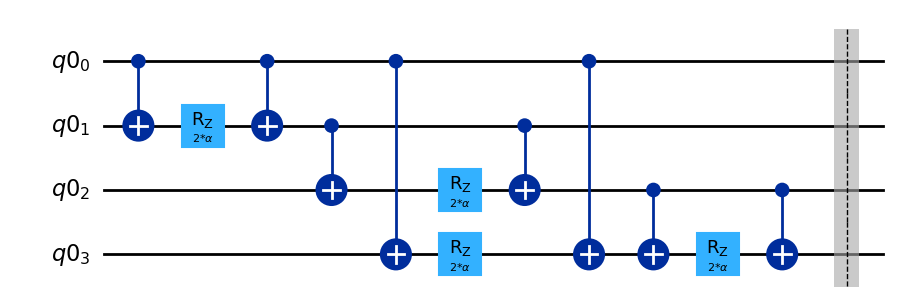

In [8]:

alpha = Parameter("$\\alpha$")
qc = problem_hamiltonian(G,A,alpha=alpha)
qc.decompose().draw(output="mpl")

<span style="color: red;">EXERCISE 5.1</span> - Implement the quantum circuit for the QAOA *general* initial Hamiltonian.

In [9]:
### Solution ###
def initial_hamiltonian(n_qubits=1, beta=1):
    qc = QuantumCircuit(n_qubits, name="$H_0$")
    qc.rx(2*beta, range(n_qubits))

    return qc

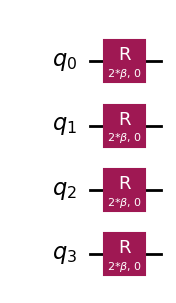

In [10]:
n_qubits = 4

beta = Parameter("$\\beta$")
qc = initial_hamiltonian(n_qubits, beta=beta)

qc.decompose().draw(output="mpl")

<span style="color: red;">EXERCISE 5.2</span> - Implement the quantum circuit for the QAOA initial state.

In [11]:
### Solution ###
def qaoa_initial_state(n_qubits=1):
    qc = QuantumCircuit(n_qubits, name="$S$")
    qc.h(range(n_qubits))

    return qc

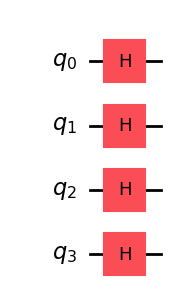

In [12]:
n_qubits = 4

qc = qaoa_initial_state(n_qubits=n_qubits)

qc.draw(output="mpl")

<span style="color: red;">EXERCISE 5.3</span> - Compose each block to form the full QAOA circuit. Remember that we want several of layers $p$ to increase the expressivity of our model.

In [13]:
def QAOA(n_qubits=1, G=None, params=None, p=1):

    qc = QuantumCircuit(n_qubits)
    qc = qc.compose(qaoa_initial_state(n_qubits=n_qubits))#, range(n_qubits))
    qc.barrier()
    
    for l in range(0,len(params),2):
        qc = qc.compose(problem_hamiltonian(G, A, alpha=params[l]))#, range(n_qubits))
        qc = qc.compose(initial_hamiltonian(n_qubits=n_qubits, beta=params[l+1]))#, range(n_qubits))
        qc.barrier()

    return qc 
    

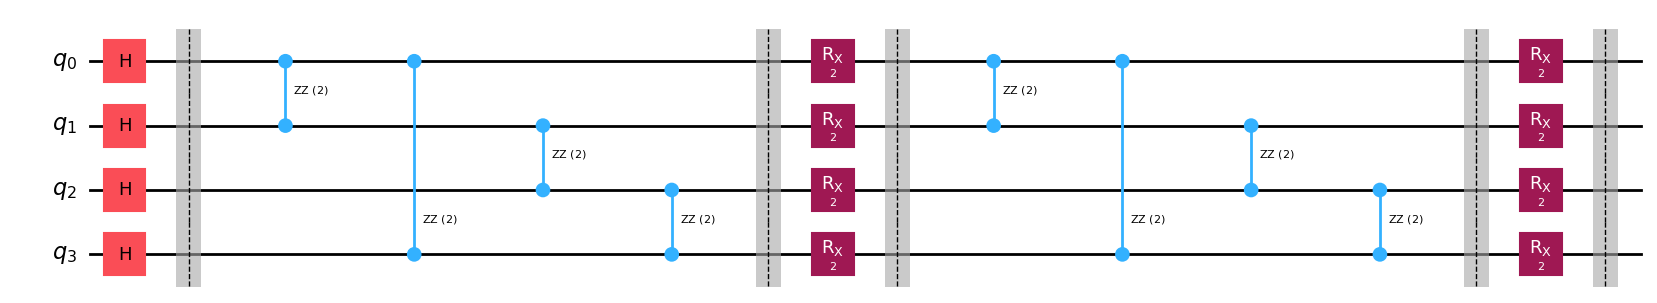

In [14]:
n_qubits = 4

p=2
params = np.ones(2*p)

full_qaoa_circuit = QAOA(n_qubits=n_qubits, G=G, params=params, p=p)
full_qaoa_circuit.draw(output="mpl")

<span style="color: red;">EXERCISE 5.4</span> - Define a function that return the cost in terms of the number of layers you put in QAOA circuit

In [15]:
def loss_function(x,counts):
    loss=0
    for i, j in G.edges():
        if x[i] != x[j]:
            loss -= 1
        
    loss *= counts
    return loss

In [16]:
def cost_function(n_qubits=1, G=None, params=None, p=1):

    full_qaoa_circuit = QAOA(n_qubits=n_qubits, G=G, params=params, p=p)
    full_qaoa_circuit.measure_all()

    shots = 2048
    probs  = execute_circuit(full_qaoa_circuit, shots=shots, primitive="sampler", binary=True, reverse=True)

    cost = 0
    for (x,prob) in probs.items():
        cost+=loss_function(x, prob)
    
    cost /= shots

    return cost

In [17]:
print(cost_function(n_qubits=n_qubits, G=G, params=np.ones(2*p), p=1))


-7.581710815429688e-05


### Maximize cut - equal to minimize cost


In [21]:
from qiskit_algorithms.optimizers import COBYLA, SPSA

p=2
pp = np.ones(2*p)

#optimizer = COBYLA()
optimizer = SPSA()


objective_function = lambda pp: cost_function(n_qubits=n_qubits, G=G, params=pp, p=p)

res = optimizer.minimize(objective_function, pp)

In [22]:
print(res)

{   'fun': -0.0019311904907226562,
    'jac': None,
    'nfev': 200,
    'nit': 100,
    'njev': None,
    'x': array([-0.70125779,  0.44975381,  1.16658999, -0.87337151])}


<span style="color: red;">EXERCISE 5.5</span> - Extract basis state with higher probability

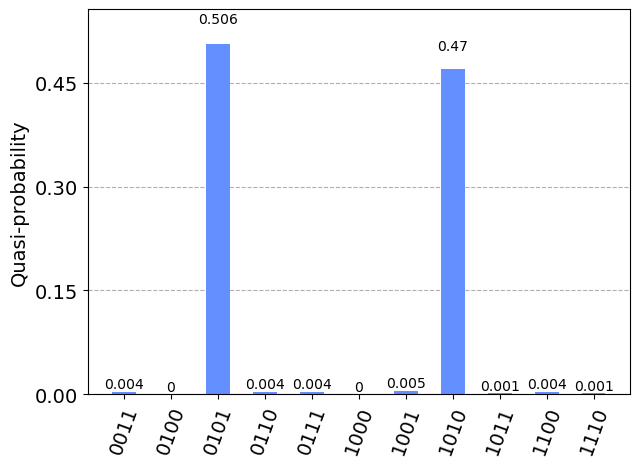

In [23]:
new_qc = QAOA(n_qubits=n_qubits, G=G, params=res.x, p=p)
new_qc.measure_all()

#new_qc.decompose().draw(output="mpl")
counts = execute_circuit(new_qc, shots=2048, primitive="sampler", binary=True, reverse=True)
                         
plot_histogram(counts)

## 8. QAOA from qiskit_algorithms <a id="qiskit_algorithms"></a>

In [24]:
from qiskit_optimization.applications import Maxcut

In [25]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()

print(qp)

qubitOp, offset = qp.to_ising()

print(qubitOp)

maximize -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 2*x_2 + 2*x_3 (4 variables, 0 constraints, 'Max-cut')
SparsePauliOp(['IIZZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [37]:
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA,ADAM,SPSA


In [41]:
n_reps = 2
pp = np.ones(2*n_reps)

qaoa_mes = QAOA(sampler=Sampler(), reps=n_reps, optimizer=COBYLA(), initial_point=pp)
s = qaoa_mes.compute_minimum_eigenvalue(qubitOp)

print(s)

{   'aux_operators_evaluated': None,
    'best_measurement': {   'bitstring': '0101',
                            'probability': 0.4999999525344007,
                            'state': 5,
                            'value': (-2+0j)},
    'cost_function_evals': 88,
    'eigenstate': {   0: 4e-16,
                      1: 8.2030801e-09,
                      2: 8.2030801e-09,
                      3: 8.3317289e-09,
                      4: 8.2030801e-09,
                      5: 0.4999999505242212,
                      6: 8.3317289e-09,
                      7: 8.2030801e-09,
                      8: 8.2030801e-09,
                      9: 8.3317289e-09,
                      10: 0.4999999505242214,
                      11: 8.2030801e-09,
                      12: 8.3317289e-09,
                      13: 8.2030801e-09,
                      14: 8.2030801e-09,
                      15: 4e-16},
    'eigenvalue': -1.9999998020968834,
    'optimal_circuit': <qiskit.circuit.quantumcircuit

In [42]:
print(s.best_measurement)

{'state': 5, 'bitstring': '0101', 'value': (-2+0j), 'probability': 0.4999999525344007}


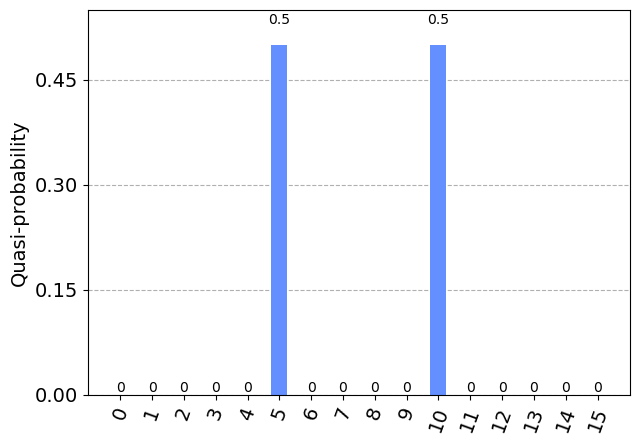

In [43]:
plot_histogram(s.eigenstate)

#### 6. References
[1] - Ising formulations of many NP problems - https://arxiv.org/pdf/1302.5843.pdf

[2] - Quantum computation by adiabatic evolution - https://arxiv.org/abs/quant-ph/0001106

[3] - A Quantum Approximate Optimization Algorithm - https://arxiv.org/abs/1411.4028

[4] - From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz - https://arxiv.org/abs/1709.03489

[5] - Quantum Approximate Optimization Algorithm - https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html

[6] - Lecture 5.2 - Introduction to the Quantum Approximate Optimization Algorithm and Applications - https://www.youtube.com/watch?v=YpLzSQPrgSc&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=14

[7] - Review on barren plateaus - https://arxiv.org/abs/2405.00781

